In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from modules_gd.model import VAE
from modules_gd.data import MSA_Dataset

First, get PF00565 data

In [2]:
MSA_id565 = "PF00565"
query_seq_id565 = "SND1_HUMAN/552-660"
data_path565 = f"data/Ding/processed/{MSA_id565}"

In [3]:
## read in binary representation of MSA
with open(f"{data_path565}/seq_msa_binary.pkl", 'rb') as file_handle:
    msa_binary565 = torch.tensor(pickle.load(file_handle))
# Number of sequences
n_seq565 = msa_binary565.shape[0]
# Dimensions of one-hot encoding
nl565 = msa_binary565.shape[1]
nc = msa_binary565.shape[2]
# Print shape
msa_binary565.shape

torch.Size([7912, 103, 21])

In [4]:
## each sequence has a label
with open(f"{data_path565}/seq_names.pkl", 'rb') as file_handle:
    seq_names565 = pickle.load(file_handle)

Next, get PF00041 data

In [5]:
MSA_id41 = "PF00041"
query_seq_id41 = "TENA_HUMAN/804-884"
data_path41 = f"data/Ding/processed/{MSA_id41}"

In [6]:
## read in binary representation of MSA
with open(f"{data_path41}/seq_msa_binary.pkl", 'rb') as file_handle:
    msa_binary41 = torch.tensor(pickle.load(file_handle))
# Number of sequences
n_seq41 = msa_binary41.shape[0]
# Dimensions of one-hot encoding
nl41 = msa_binary41.shape[1]
# Print shape
msa_binary41.shape

torch.Size([43743, 73, 21])

In [7]:
## each sequence has a label
with open(f"{data_path41}/seq_names.pkl", 'rb') as file_handle:
    seq_names41 = pickle.load(file_handle)

Now combine the two datasets. We first choose a random sample of 10,000 sequences from the PF00041 data-set so that it doesn't dominate the combined dataset

In [8]:
perm = torch.randperm(msa_binary41.size(0))
idx = perm[:10_000]
msa_binary41 = msa_binary41[idx]
seq_names41 = [seq_names41[i] for i in idx]

Now we pad the PF00041 MSA to match the length of the PF00565 MSA. To test model ability to distinguish families robustly, can fill the padding of the PF00041 sequences with amino acids based on the baseline frequency of amino acids in the PF00565 MSA! 

In [9]:
# Add padding to the PF00041 MSA to match the length of the PF00565 MSA with amino acids drawn from the background frequencies
padding_size = msa_binary565.shape[1] - msa_binary41.shape[1]
padding = torch.zeros(msa_binary41.shape[0], padding_size, msa_binary41.shape[2])
# Get baseline frequencies of amino acids in the PF00565 MSA
probs = torch.mean(msa_binary565, dim=(0,1)) 
rand_aa = np.random.choice(nc, size=padding.shape[:2], p=probs)
# Fill in ones in the correct positions to get one-hot encodings
for i in range(padding.shape[0]):
    for j in range(padding.shape[1]):
        aa = rand_aa[i, j]
        padding[i, j, aa] = 1
# Alternatively, make all the padding gap characters
# padding[:,:, 0] = 1 # This is one hot representation of the gap character

And now concatenate the two MSAs. 

In [10]:
msa_binary41 = torch.cat([padding, msa_binary41], dim=1) # padding appended to the beginning of the sequences
combined_msa = torch.cat([msa_binary565, msa_binary41], dim=0)
combined_seq_names = seq_names565 + seq_names41
combined_msa.shape

torch.Size([17912, 103, 21])

Instantiate the dataset with equal sequence weights

In [11]:
seq_weight = np.ones(combined_msa.shape[0])/(combined_msa.shape[0])
#print(np.sum(seq_weight))
data = MSA_Dataset(combined_msa, seq_weight, combined_seq_names)

## Model training

In [12]:
# Define how to do an epoch of training
def train(model, device, train_loader, optimizer, epoch, verbose):

  model.train()
  running_elbo = []

  for batch_idx, (msa, weight, _) in enumerate(train_loader):
    msa, weight = msa.to(device), weight.to(device)
    optimizer.zero_grad()
    loss = (-1)*model.compute_weighted_elbo(msa, weight)
    loss.backward()
    optimizer.step()
    elbo_scalar = -loss.item()
    if verbose:
      print("Epoch: {:>4}, Step: {:>4}, loss: {:>4.2f}".format(epoch, batch_idx, elbo_scalar), \
            flush = True)
    running_elbo.append(elbo_scalar)

  return running_elbo

# Define how to evaluate the model on the validation data
def eval(model, device, valid_loader, recon = False):

  model.eval()
  elbos = []
  if recon:
    recon_accs = []
  with torch.no_grad():
    for (msa, _, _) in valid_loader:
      msa = msa.to(device)
      # compute elbo loss
      elbo = model.compute_elbo_with_multiple_samples(msa, 1) # how many samples to use for IWAE estimate of ELBO
      elbo_scalar = torch.mean(elbo).item()
      elbos.append(elbo_scalar)


      if recon:
        # compute proportion of amino acids correctly reconstructed
        real = torch.argmax(msa, -1)
        mu, _ = model.encoder(msa)
        p = torch.exp(model.decoder(mu))
        preds = torch.argmax(p, -1)
        recon_acc = torch.sum(real == preds)/real.nelement()
        recon_acc_scalar = recon_acc.data.item()
        recon_accs.append(recon_acc_scalar)

  return elbos, recon_accs

In [13]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Hyperparameters
num_epochs = 25
wd = 0.01
dim_lat = 2
bs = 32
verbose = False

cpu


In [14]:
data_loader = DataLoader(data, batch_size = bs, shuffle = True)

In [15]:
model = VAE(nl=nl565, nc=nc, dim_latent_vars=dim_lat).to(device)
optimizer = optim.Adam(model.parameters()) # optionally include `weight_decay = wd` in the optimizer

train_elbos = []
test_elbos = []
test_recon_accs = []
for epoch in range(num_epochs):
  batch_elbos, batch_recon_accs = eval(model, device, data_loader, recon = True)
  epoch_test_elbo, epoch_test_recon_acc = np.mean(batch_elbos), np.mean(batch_recon_accs)
  test_elbos.append(epoch_test_elbo)
  test_recon_accs.append(epoch_test_recon_acc)
  print(f"Test elbo for epoch {epoch}: {epoch_test_elbo}")
  print(f"Test reconstruction accuracy for fold epoch {epoch}: {epoch_test_recon_acc}")
  batch_elbos = train(model, device, data_loader, optimizer, epoch, verbose)
  epoch_train_elbo = np.mean(batch_elbos)
  train_elbos.append(epoch_train_elbo)
  print(f"Training elbo for epoch {epoch}: {epoch_train_elbo}")

Test elbo for epoch 0: -314.6641501035009
Test reconstruction accuracy for fold epoch 0: 0.03725746219445552
Training elbo for epoch 0: -199.7128652789763
Test elbo for epoch 1: -179.8161081481725
Test reconstruction accuracy for fold epoch 1: 0.47137511473681243
Training elbo for epoch 1: -176.21748089103826
Test elbo for epoch 2: -172.06862718368924
Test reconstruction accuracy for fold epoch 2: 0.4913170369075877
Training elbo for epoch 2: -170.62779164945795
Test elbo for epoch 3: -168.29325560721614
Test reconstruction accuracy for fold epoch 3: 0.5040440433791705
Training elbo for epoch 3: -166.73196890779903
Test elbo for epoch 4: -164.52249162645035
Test reconstruction accuracy for fold epoch 4: 0.5186810120940208
Training elbo for epoch 4: -163.77143202917205
Test elbo for epoch 5: -161.38523984473377
Test reconstruction accuracy for fold epoch 5: 0.526067311369947
Training elbo for epoch 5: -161.3585074629457
Test elbo for epoch 6: -159.3445374318088
Test reconstruction accur

## Look at embeddings 

In [16]:
combined_msa = combined_msa.to(torch.float32)
with torch.no_grad():
  mu, sigma = model.encoder(combined_msa)
mu.shape, sigma.shape

(torch.Size([17912, 2]), torch.Size([17912, 2]))

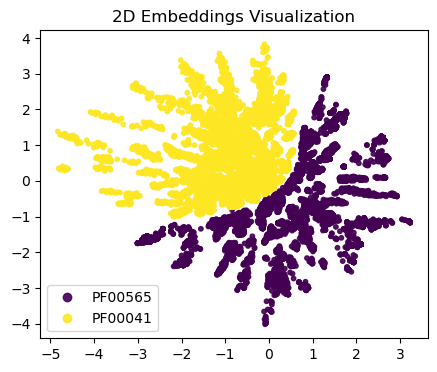

In [17]:
# Create a scatter plot
plt.figure(figsize=(5, 4))
scatter = plt.scatter(mu[:, 0], mu[:, 1], s=10, alpha=0.9, c = np.array([0]*n_seq565 + [1]*10_000))

# Add a title
plt.title('2D Embeddings Visualization')

#Add a legend
plt.legend(handles=scatter.legend_elements()[0], labels = ["PF00565", "PF00041"])

# Show the plot
plt.show()
